In [1]:
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torchvision import transforms, datasets

import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

from fovperi.fov.fov2 import getFov, reverseMapPixel, reverseMapPixel_Initial, generate_fovea 

from pytorch_lightning.loggers import WandbLogger

from PIL import Image

c:\Users\appel\anaconda3\envs\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Image visualization

In [2]:
def decode_seg_map_sequence(label_masks, dataset='cityscapes'):
    rgb_masks = []
    for label_mask in label_masks:
        rgb_mask = decode_segmap(label_mask, dataset)
        rgb_masks.append(rgb_mask)
    rgb_masks = torch.from_numpy(np.array(rgb_masks).transpose([0, 3, 1, 2]))
    return rgb_masks

mapping_20 = { 
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 1,
    8: 2,
    9: 0,
    10: 0,
    11: 3,
    12: 4,
    13: 5,
    14: 0,
    15: 0,
    16: 0,
    17: 6,
    18: 0,
    19: 7,
    20: 8,
    21: 9,
    22: 10,
    23: 11,
    24: 12,
    25: 13,
    26: 14,
    27: 15,
    28: 16,
    29: 0,
    30: 0,
    31: 17,
    32: 18,
    33: 19,
    -1: 0
}

def decode_segmap(label_mask, dataset='cityscapes', plot=False):
    """Decode segmentation class labels into a color image
    Args:
        label_mask (np.ndarray): an (M,N) array of integer values denoting
          the class label at each spatial location.
        plot (bool, optional): whether to show the resulting color image
          in a figure.
    Returns:
        (np.ndarray, optional): the resulting decoded color image.
    """

    if dataset == 'cityscapes':
        n_classes = 19
        label_colours = get_cityscapes_labels()
        # Remapping using mapping_20
        for k, v in mapping_20.items():
            label_mask[label_mask == k] = v


    r = label_mask.copy()
    g = label_mask.copy()
    b = label_mask.copy()
    for ll in range(0, n_classes):
        r[label_mask == ll] = label_colours[ll, 0]
        g[label_mask == ll] = label_colours[ll, 1]
        b[label_mask == ll] = label_colours[ll, 2]
    rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    if plot:
        plt.imshow(rgb)
        plt.show()
    else:
        return rgb

def get_cityscapes_labels():
    return np.array([
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32]])

def visualize_tensor(tensor):
    # if tensor size len == 3
    if len(tensor.size()) == 3:
        return Image.fromarray(np.array(tensor.permute(1,2,0)*255, dtype=np.uint8))

def visualize_segmap(segmmap):
    return Image.fromarray(decode_segmap(np.array(segmmap)), dtype=np.uint8)

## Foveation modules

In [3]:
class FoveatedCompression:
    def __init__(self, N=256, p0=22, Nr=18, bio_foveation=True, add_coords=False):
        self.N = N
        self.p0 = p0
        self.Nr = Nr
        self.bio_foveation = bio_foveation
        self.add_coords = add_coords
        self.fovCenter = int((N - 2 * p0) / 2)
        self.fovSize = 2 * (p0 + Nr) + 1
        self.fovX, self.fovY = N // 2 - self.p0, N // 2 - self.p0

        # Initialize the reverse mapping and foveation functions
        # self.reverseMapPixel_Initial = reverseMapPixel_Initial(N=N, p0=p0, Nr=Nr, fovCenter=self.fovCenter, bio=bio_foveation)
        # self.reverseMapPixel = reverseMapPixel(N=N, p0=p0, Nr=Nr, bio=bio_foveation)
        self.getFovead = getFov(N=N, p0=p0, Nr=Nr, bio=bio_foveation, add_coords=add_coords)

    def foveated_compression(self, image):
        return np.array(self.getFovead(image, self.fovX, self.fovY, add_coords=False), dtype=np.uint8)
    
    def reconstruct(self, image):
        reconstructed, interpolated = self.getFovead(image, self.fovX, self.fovY, add_coords=False, reverse=True)
        return np.array(reconstructed, dtype=np.uint8), np.array(interpolated, dtype=np.uint8)


In [4]:
class FoveatedTransform:
    def __init__(self, N=256, p0=22, Nr=18, bio_foveation=True, add_coords=False):
        self.foveated_compression = FoveatedCompression(N, p0, Nr, bio_foveation, add_coords)

    def compress(self, tensor):
        # Convert tensor to numpy array
        tensor = torch.Tensor(tensor)
        array = np.array(tensor.permute(1,2,0)*255, dtype=np.uint8)
        # Apply foveated compression
        foveated_image = self.foveated_compression.foveated_compression(array)
        # Convert numpy array back to tensor
        return transforms.ToTensor()(foveated_image)
    
    def reconstruct(self, tensor):
        # Convert tensor to numpy array
        tensor = torch.Tensor(tensor)
        if len(tensor.size()) == 3:
            array = np.array(tensor.permute(1,2,0)*255, dtype=np.uint8)
        else:
            array = np.array(tensor*255, dtype=np.uint8)
        # Apply foveated compression
        reconstructed, interpolated = self.foveated_compression.reconstruct(array)
        # Convert numpy array back to tensor
        return transforms.ToTensor()(reconstructed), transforms.ToTensor()(interpolated)

    def __repr__(self):
        return self.__class__.__name__ + '()'
    
foveated_transform = FoveatedTransform(N=256, p0=22, Nr=18, bio_foveation=True, add_coords=False)

### Transforms

In [39]:
input_transforms = transforms.Compose([
    # To numpy array
    # transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    foveated_transform.compress
])

target_transform=transforms.Compose([
            transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST), # NEAREST is important for labels
            transforms.PILToTensor(),
            # divide by 255 to get values between 0 and 1
            transforms.Lambda(lambda mask: mask/255),  # Remove the channel dimension and convert to long
            foveated_transform.compress,
            # transforms.Resize((96, 96), interpolation=transforms.InterpolationMode.NEAREST),
            transforms.Lambda(lambda mask: (255*mask[0, :, :]).long()),  # Remove the channel dimension and convert to long
        ])

output_transforms = transforms.Compose([
    # To numpy array
    # transforms.ToTensor(),
    foveated_transform.reconstruct
])

target_output_transforms = transforms.Compose([
    # To numpy array
    # transforms.ToTensor(),
    # add dimension for channel
    # transforms.Lambda(lambda mask: mask.unsqueeze(0)),
    foveated_transform.reconstruct
])

# Test

In [6]:
# Open test image
test_image = Image.open("data\\test_image.jpeg")

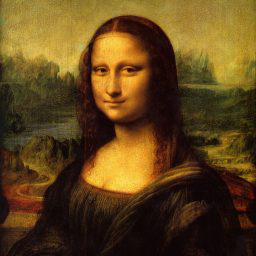

In [7]:
test_image

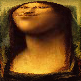

In [8]:
# Test FoveatedTransform
compressed = input_transforms(test_image)

visualize_tensor(compressed)

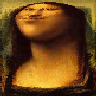

In [9]:
resize_up = transforms.Resize((96, 96), interpolation=transforms.InterpolationMode.NEAREST)
resized_up = resize_up(compressed)

visualize_tensor(resized_up)

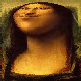

In [10]:
resize_down = transforms.Resize((81, 81), interpolation=transforms.InterpolationMode.NEAREST)
resized_down = resize_down(resized_up)

visualize_tensor(resized_down)

(81, 81, 3)
(6561,)


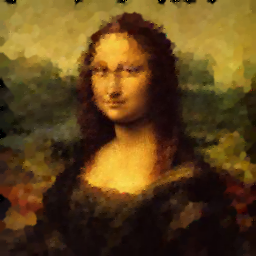

In [11]:
reconstructed = output_transforms(compressed)

visualize_tensor(reconstructed[1])

# Cityscapes

In [40]:
train_dataset = datasets.Cityscapes(
    root='data/cityscapes', 
    split='train', 
    mode='fine',
    target_type='semantic',
    transform=input_transforms,
    target_transform=target_transform
)

In [41]:
images, masks = next(iter(train_dataset))

In [42]:
images.shape, masks.shape

(torch.Size([3, 81, 81]), torch.Size([81, 81]))

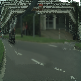

In [43]:
visualize_tensor(images)

(81, 81, 3)
(6561,)


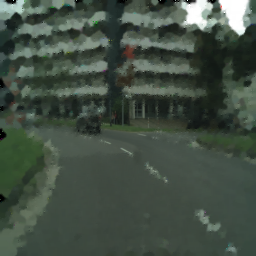

In [44]:
reconstructed = output_transforms(images)

visualize_tensor(reconstructed[1])

In [45]:
images.shape

torch.Size([3, 81, 81])

In [46]:
masks.shape

torch.Size([81, 81])

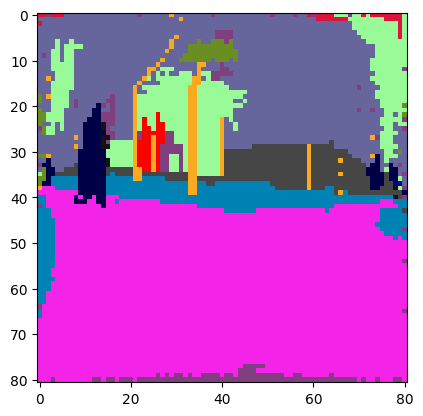

In [47]:
plt.imshow(decode_segmap(np.array(masks)))

In [50]:
masks.shape

torch.Size([81, 81])

In [48]:
reconstructed = output_transforms(masks)

# plt.imshow(decode_segmap(np.array(reconstructed[1][0])))

(81, 81)
(6561,)


ValueError: cannot reshape array of size 6561 into shape (6561,3)